In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time

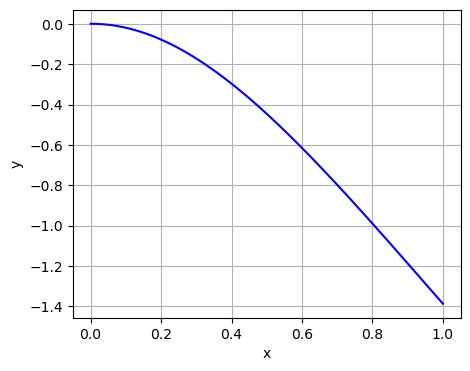

In [2]:
# Definir la función y(x)
def f(x):
    if x == 0:
        return float(0)
    return -2 * np.log(1 + x**2)

# Crear un rango de valores de x desde 0 hasta 1
x_values = np.linspace(0.0, 1, 400)  # Empezamos desde 0.001 para evitar logaritmo de 0

# Calcular los valores de y para cada x
y_values = np.array([f(x) for x in x_values])

# Graficar la función
plt.figure(figsize=(5, 4))
plt.plot(x_values, y_values, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [3]:
# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [4]:
def calculate_first_n_legendre_polynomials(x: torch.Tensor, n: int) -> torch.Tensor:
    """
    Calcula los primeros n polinomios de Legendre en los puntos especificados.

    Entradas:
    x (torch.Tensor): Un tensor de PyTorch que contiene los puntos en los que se evaluarán los polinomios de Legendre.
    n (int): El grado del polinomio de Legendre más alto que se calculará.

    Salidas:
    (torch.Tensor): Un tensor de PyTorch que contiene los valores de los primeros n polinomios de Legendre en los puntos especificados.
    """

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n + 1):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

In [5]:
class OrthogonalNeuralNetwork(nn.Module):
    def __init__(self, n: int, lb: float, ub: float):
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = nn.Parameter(torch.zeros(n+1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = calculate_first_n_legendre_polynomials(x, self.n)

        # Selecciona los polinomios de Legendre necesarios para la aproximación
        selected_legendre_polynomials = legendre_polynomials[:, :self.n + 1]

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.atan(torch.matmul(selected_legendre_polynomials, self.weights[:self.n + 1]))

In [6]:
# class OrthogonalNeuralNetwork(nn.Module):
#     def __init__(self, n: int, lb: float, ub: float):
#         super(OrthogonalNeuralNetwork, self).__init__()
#         self.n = n
#         self.lb = lb
#         self.ub = ub
#         self.weights = nn.Parameter(torch.zeros(n + 1))  # Coeficientes como parámetros del modelo

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Normalización ajustada para manejar valores cercanos a cero
#         x = (2 * x - (self.ub + self.lb)) / (self.ub - self.lb)
#         legendre_polynomials = self.calculate_first_n_legendre_polynomials(x, self.n)
#         selected_legendre_polynomials = legendre_polynomials[:, :self.n + 1]
#         return torch.matmul(selected_legendre_polynomials, self.weights[:self.n + 1])

#     def calculate_first_n_legendre_polynomials(self, x: torch.Tensor, n: int) -> torch.Tensor:
#         legendre_polynomials = [torch.ones_like(x), x]
#         for i in range(2, n + 1):
#             a = (2 * i - 1) / i
#             b = (i - 1) / i
#             legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]
#             legendre_polynomials.append(legendre_polynomial)
#         return torch.stack(legendre_polynomials, dim=1)



El modelo tiene 51 parámetros.
Tiempo de entrenamiento: 4.248305797576904 segundos


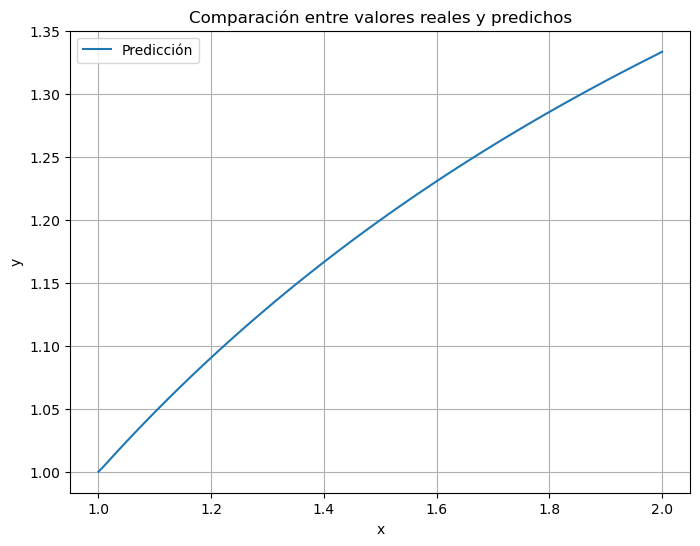

In [10]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Definir la función y(x)
def f(x):
    zero_tensor = torch.tensor(0.0, dtype=torch.float32)
    return torch.where(torch.abs(x) < 1e-8, zero_tensor, -2 * torch.log(1 + x**2))

# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

# Definir el intervalo x

lb = 1  # Ajuste mínimo para evitar valores muy cercanos a cero
ub = 2
device = torch.device('cpu')  # Usamos CPU para este ejemplo

x = torch.tensor(np.linspace(lb, ub, 100), dtype=torch.float32, requires_grad=True).to(device)
y = f(x)

model = OrthogonalNeuralNetwork(50, lb, ub).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros.')

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

# Definir la función de cierre
def closure():
    optimizer.zero_grad()
    y_pred = model(x)
    y_t = 2/3 + x/3 + (x-1)*(x-2)*y_pred  
    y_xx = derivative(y_t, x, order=2)
    residuo = ((y_t**3 - 2*y_t**2)/(2*x**2)) - y_xx  
    loss = torch.sum((residuo - torch.zeros_like(residuo))**2)
    loss.backward(retain_graph=True)
    return loss
 

# Función para entrenar el modelo
def train_model(epochs):
    start_time = time.time()
    for epoch in range(epochs):
        optimizer.step(closure)
    end_time = time.time()
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model(100)

# Predecir los valores de y
with torch.no_grad():
    y_pred = model(x)
    y_pred = 2/3 + x/3 + (x-1)*(x-2)*y_pred  
# Convertir tensores a numpy para visualización
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()
y_pred = y_pred.cpu().numpy()

# Graficar los resultados
plt.figure(figsize=(8, 6))
#plt.plot(x, y, label='Real')
plt.plot(x, y_pred, label='Predicción')
plt.legend()
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
